In [1]:
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
import numpy as np
from scipy.spatial.distance import cdist

In [2]:
def pdf_to_cdf(x_grid,kde):
    kde = kde.evaluate(x_grid)
    cdf = np.cumsum(kde)
    cdf = cdf / cdf[-1]
    return cdf

In [3]:
def EDA_calc (data, metric='euclidean'):
    L, W = data.shape
    EDA = {}
    
    dist = cdist(data, data, metric=metric)
    
    EDA['Centrality'] = 1/np.sum(dist,axis=0)
    EDA['CumulativeProximity'] = np.sum(dist**2,axis=0)
    EDA['SquareCentrality'] = 1/EDA['CumulativeProximity']
    EDA['Eccentricity'] = 2*EDA['CumulativeProximity']/np.sum(EDA['CumulativeProximity'])
    EDA['Density'] = L/EDA['Eccentricity']    
    
    return EDA

In [4]:
##########################################################
# ------------------------------------------------------ #
# ----------------------- LOADING ---------------------- #
# ------------------------------------------------------ #
##########################################################
# Firstly the model loads the background and signal data, 
# then it removes the attributes first string line, which 
# are the column names, in order to avoid NaN values in 
# the array.

print('         ==== Commencing Initiation ====\n')

### Background
b_name='Input_Background_1.csv'
background = np.genfromtxt(b_name, delimiter=',')
background = background[1:,:]
print("     .Background Loaded..." )
print("     .Background shape: {}".format(background.shape))

### Signal
s_name='Input_Signal_1.csv'
signal = np.genfromtxt(s_name, delimiter=',')
signal = signal[1:,:]
print("     .Signal Loaded...")
print("     .Signal shape: {}\n".format(signal.shape))

print('\n          ==== Initiation Complete ====\n')
print('=*='*17 )
print('      ==== Commencing Data Processing ====')

         ==== Commencing Initiation ====

     .Background Loaded...
     .Background shape: (543500, 21)
     .Signal Loaded...
     .Signal shape: (522467, 21)


          ==== Initiation Complete ====

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
      ==== Commencing Data Processing ====


In [13]:
##########################################################
# ------------------------------------------------------ #
# --------------------- INITIATION --------------------- #
# ------------------------------------------------------ #
##########################################################
### Define User Variables ###

# List of Granularities
gra_list = [i for i in range(1,11)]

# Number of Iterations
iterations = 1

# Number of events
total = 10000

# Number of Data-set divisions
windows = 334

# Percentage of background samples on the testing phase
background_percent = 0.99

# Percentage of samples on the training phase
test_size = 0.3

# Percentage of background samples to divide the data-set
dat_set_percent = total/len(background)
print(dat_set_percent)

0.01839926402943882


In [14]:
for n_i in range(iterations):
    print('\n     => Iteration Number', (n_i+1) )

    # Divide data-set into training and testing sub-sets
    print('         .Dividing training and testing sub-sets')

    _,reduced_background = train_test_split(background, test_size=dat_set_percent)

    background_seed, streaming_background = train_test_split(reduced_background, test_size=test_size)
    
    n_signal_samples = len(streaming_background)*(1-background_percent)

    _,streaming_background = train_test_split(streaming_background, test_size=background_percent)
    
    # Defining number of events Signal events on online phase.
    _,reduced_signal = train_test_split(signal, test_size=n_signal_samples/len(signal))

    # Concatenating Signal and the Test Background sub-set
    streaming_data = np.vstack((streaming_background,reduced_signal))
    
    n_bd_str = len(streaming_background)
    n_sl_str = len(reduced_signal)

    print("             .Seed shape: {}".format(background_seed.shape))
    print("             .Streaming shape: {}\n".format(streaming_data.shape))
    print("             .Streaming Background shape: {}\n".format(streaming_background.shape))
    print("             .Streaming Signal shape: {}\n".format(reduced_signal.shape))

    # Normalize Data
    print('         .Normalizing Data')
    streaming_data = normalize(streaming_data,norm='max',axis=0)
    background_seed = normalize(background_seed,norm='max',axis=0)
    
    # Concatenating Signal and the Test Background sub-set
    total_data = np.vstack((background_seed,streaming_data))

    reduced_signal = streaming_data[n_bd_str:n_bd_str+n_sl_str,:]
    ### Create target

    y =np.ones((len(streaming_data)))
    y[len(streaming_background):] = -1
    y[len(background_seed):] = 0


     => Iteration Number 1
         .Dividing training and testing sub-sets
             .Seed shape: (7000, 21)
             .Streaming shape: (3001, 21)

             .Streaming Background shape: (2970, 21)

             .Streaming Signal shape: (31, 21)

         .Normalizing Data


# Original Attributes

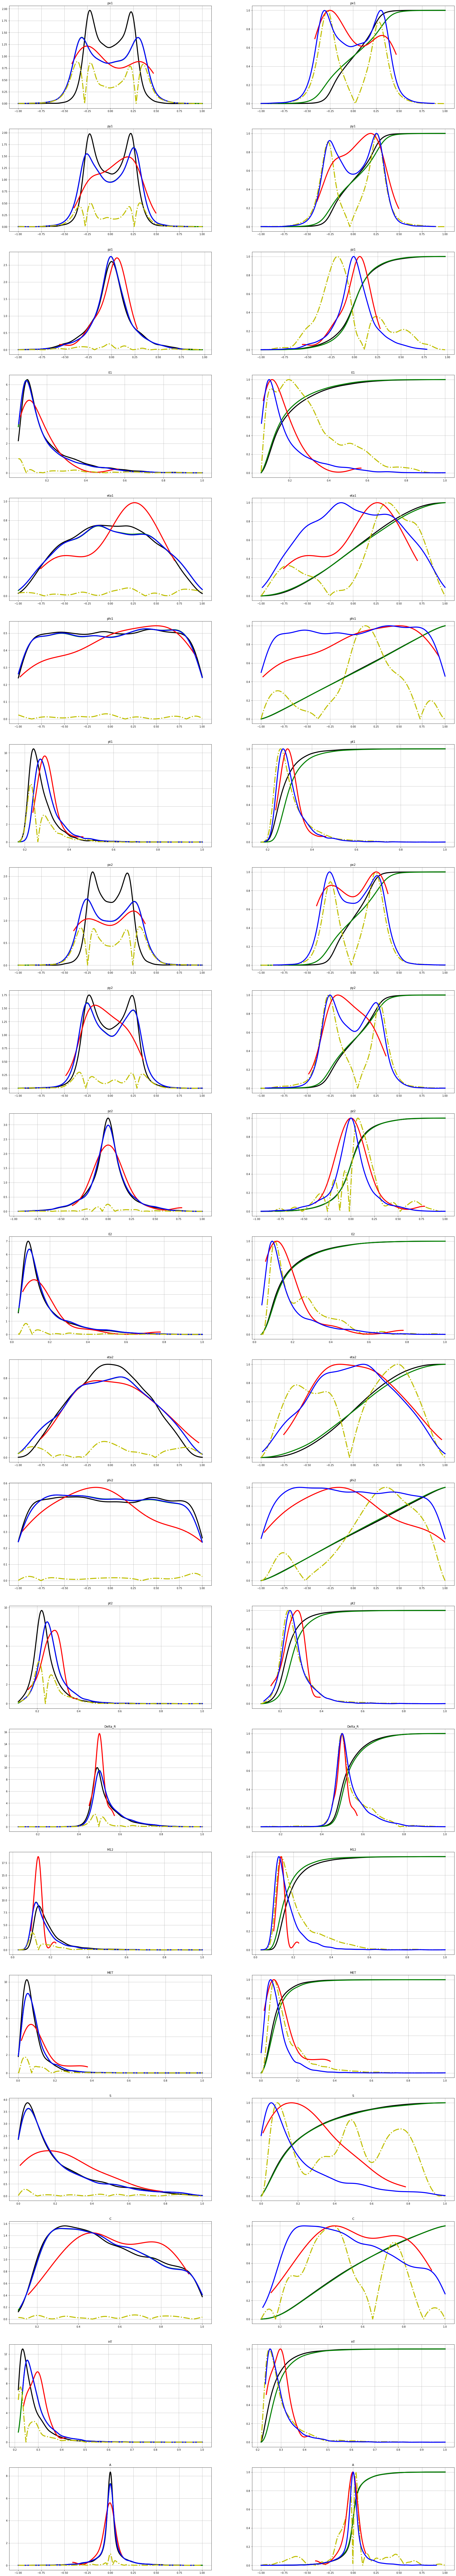

In [15]:
attributes= ["px1","py1","pz1","E1","eta1","phi1","pt1","px2","py2","pz2","E2",
             "eta2","phi2","pt2","Delta_R","M12","MET","S","C","HT","A"]

fig = plt.figure(figsize=[32,9*len(background_seed[0,:])])
ax = fig.subplots(len(background_seed[0,:]),2)

for i, att in enumerate(attributes):
    seed_var = background_seed[:,i]
    streaming_var = streaming_data[:,i]
    
    signal_streaming_var = streaming_var[n_bd_str:n_bd_str+n_sl_str]
    background_streaming_var = streaming_var[:n_bd_str]
    
    signal_streaming_var = np.sort(signal_streaming_var)
    background_streaming_var = np.sort(background_streaming_var)

    seed_kde = stats.gaussian_kde(seed_var)
    streaming_kde = stats.gaussian_kde(streaming_var)
    signal_kde = stats.gaussian_kde(signal_streaming_var)
    background_kde = stats.gaussian_kde(background_streaming_var)
    
    data_eval = np.linspace(min([min(seed_var),min(streaming_var)]),
                            max([max(seed_var),max(streaming_var)]), 
                            2000)
    background_eval = np.linspace(min(background_streaming_var),
                            max(background_streaming_var), 
                            1000)
    signal_eval = np.linspace(min(signal_streaming_var),
                            max(signal_streaming_var), 
                            1000)
    
    seed_cdf = pdf_to_cdf(data_eval,seed_kde)
    streaming_cdf = pdf_to_cdf(data_eval,streaming_kde)

    # Plot the Probability Distribuction Function (PDF)
        
    ax[i,0].plot(data_eval, seed_kde(data_eval), 'k', linewidth=4)
    ax[i,0].plot(data_eval, streaming_kde(data_eval),'g', linewidth=4)
    ax[i,0].plot(signal_eval, signal_kde(signal_eval),'r', linewidth=4)
    ax[i,0].plot(background_eval, background_kde(background_eval),'b', linewidth=4)
    ax[i,0].plot(data_eval, np.sqrt((seed_kde(data_eval) - streaming_kde(data_eval))**2),'-.y', 
            linewidth=4)

    ax[i,0].grid()
    ax[i,0].set_title(att)
    
    # Plot the Cumulative Distribuction Function (CDF)
        
    ax[i,1].plot(data_eval, seed_cdf, 'k', linewidth=4)
    ax[i,1].plot(data_eval, streaming_cdf,'g', linewidth=4)
    ax[i,1].plot(data_eval,normalize(np.sqrt((seed_cdf - streaming_cdf)**2).reshape((1,-1)),
                                        norm='max').reshape((-1))
                 ,'-.y', linewidth=4)
    ax[i,1].plot(signal_eval, normalize(signal_kde(signal_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'r', linewidth=4)
    ax[i,1].plot(background_eval, normalize(background_kde(background_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'b', linewidth=4)
    ax[i,1].grid()
    ax[i,1].set_title(att)
    
plt.show()
fig.savefig('Attributes_PDF&CDF.pdf', bbox_inches='tight')

# EDA

In [16]:
streaming_eda = EDA_calc(streaming_data,metric ='cosine')
seed_eda = EDA_calc(background_seed,metric ='cosine')

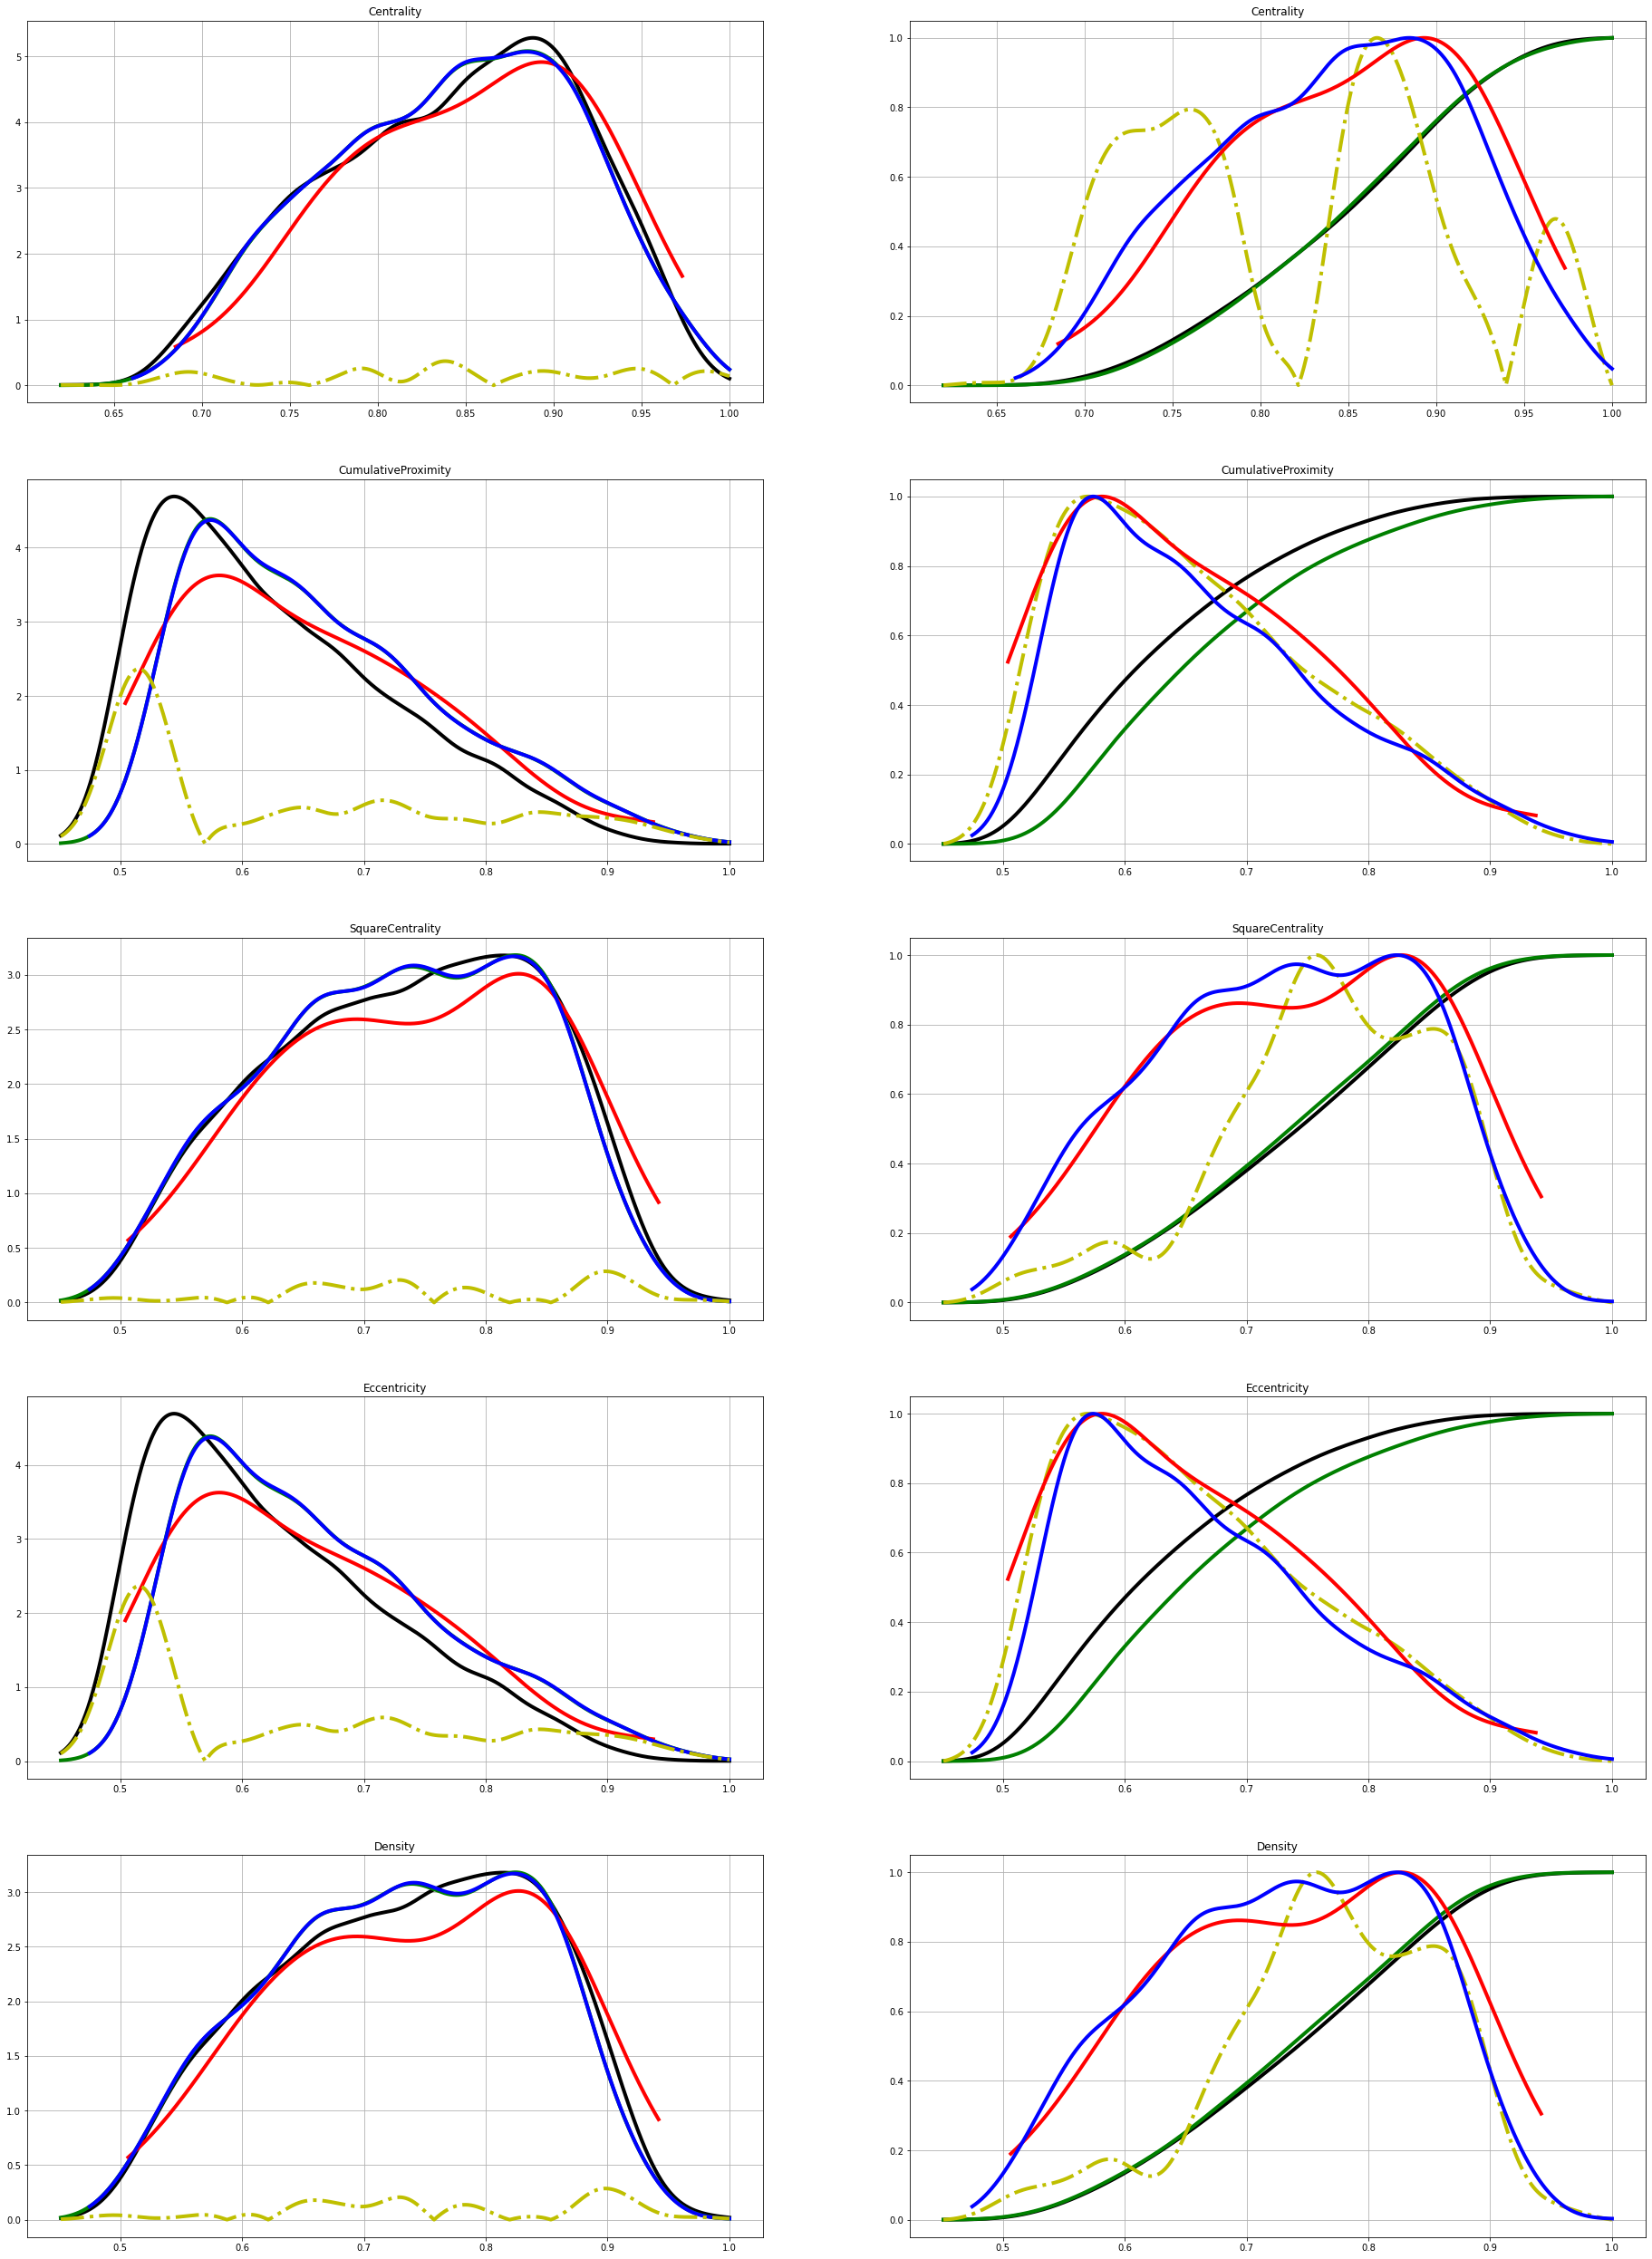

In [17]:
fig = plt.figure(figsize=[32,9*len(streaming_eda.keys())])
ax = fig.subplots(1*len(streaming_eda.keys()),2)

for i,eda in enumerate(streaming_eda):
    
    seed_var = seed_eda[eda]
    streaming_var = streaming_eda[eda]

    seed_var = normalize(seed_var.reshape((1,-1)),norm='max').reshape((-1))
    streaming_var = normalize(streaming_var.reshape((1,-1)),norm='max').reshape((-1))

    signal_streaming_var = streaming_var[n_bd_str:n_bd_str+n_sl_str]
    background_streaming_var = streaming_var[:n_bd_str]

    seed_kde = stats.gaussian_kde(seed_var)
    streaming_kde = stats.gaussian_kde(streaming_var)
    signal_kde = stats.gaussian_kde(signal_streaming_var)
    background_kde = stats.gaussian_kde(background_streaming_var)

    data_eval = np.linspace(min([min(seed_var),min(streaming_var)]),
                            max([max(seed_var),max(streaming_var)]), 
                            2000)
    background_eval = np.linspace(min(background_streaming_var),
                            max(background_streaming_var), 
                            1000)
    signal_eval = np.linspace(min(signal_streaming_var),
                            max(signal_streaming_var), 
                            1000)

    seed_cdf = pdf_to_cdf(data_eval,seed_kde)
    streaming_cdf = pdf_to_cdf(data_eval,streaming_kde)

    # Plot the Probability Distribuction Function (PDF)

    ax[i,0].plot(data_eval, seed_kde(data_eval), 'k', linewidth=4)
    ax[i,0].plot(data_eval, streaming_kde(data_eval),'g', linewidth=4)
    ax[i,0].plot(signal_eval, signal_kde(signal_eval),'r', linewidth=4)
    ax[i,0].plot(background_eval, background_kde(background_eval),'b', linewidth=4)
    ax[i,0].plot(data_eval, np.sqrt((seed_kde(data_eval) - streaming_kde(data_eval))**2),'-.y', 
                linewidth=4)
    ax[i,0].grid()
    ax[i,0].set_title(eda)

    # Plot the Cumulative Distribuction Function (CDF)

    ax[i,1].plot(data_eval, seed_cdf, 'k', linewidth=4)
    ax[i,1].plot(data_eval, streaming_cdf,'g', linewidth=4)
    ax[i,1].plot(data_eval,normalize(np.sqrt((seed_cdf - streaming_cdf)**2).reshape((1,-1)),
                                        norm='max').reshape((-1))
                 ,'-.y', linewidth=4)
    ax[i,1].plot(signal_eval, normalize(signal_kde(signal_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'r', linewidth=4)
    ax[i,1].plot(background_eval, normalize(background_kde(background_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'b', linewidth=4)
    
    ax[i,1].grid()
    ax[i,1].set_title(eda)

plt.show()
fig.savefig('EDA_cosine_PDF&CDF.pdf', bbox_inches='tight')

In [18]:
streaming_eda = EDA_calc(streaming_data)
seed_eda = EDA_calc(background_seed)

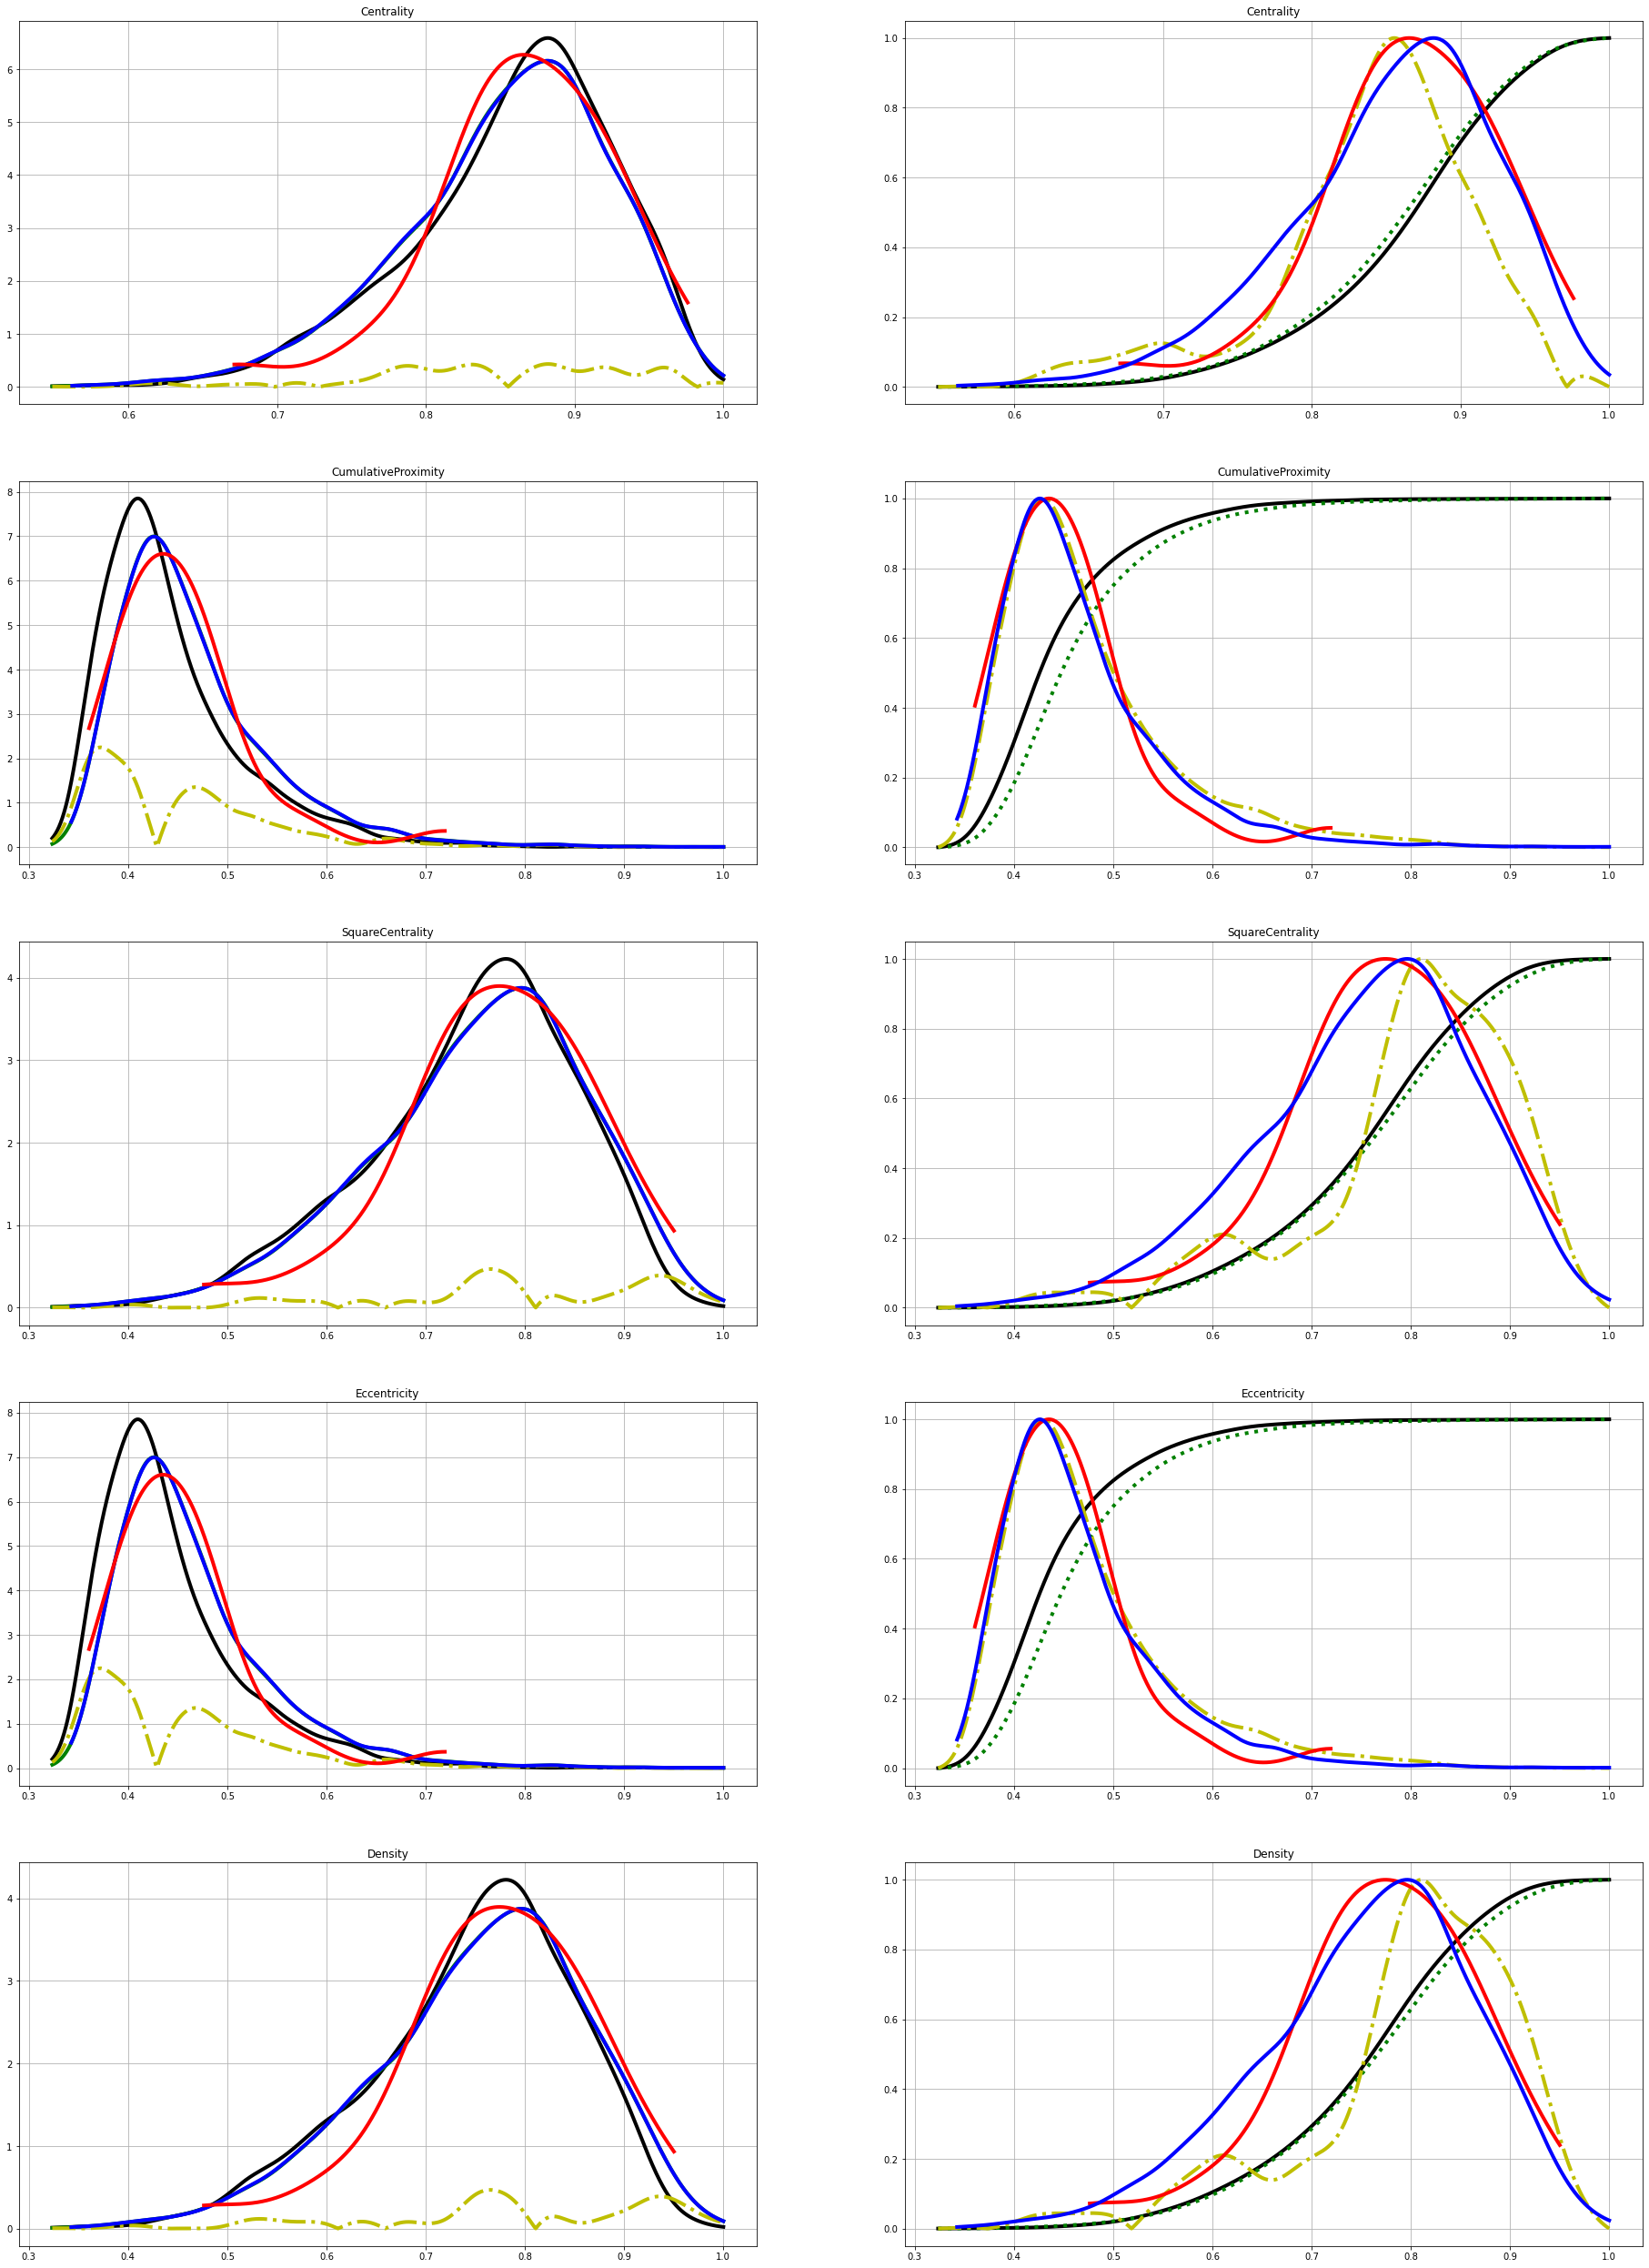

In [19]:
fig = plt.figure(figsize=[32,9*len(streaming_eda.keys())])
ax = fig.subplots(1*len(streaming_eda.keys()),2)

for i,eda in enumerate(streaming_eda):
    
    seed_var = seed_eda[eda]
    streaming_var = streaming_eda[eda]

    seed_var = normalize(seed_var.reshape((1,-1)),norm='max').reshape((-1))
    streaming_var = normalize(streaming_var.reshape((1,-1)),norm='max').reshape((-1))

    signal_streaming_var = streaming_var[n_bd_str:n_bd_str+n_sl_str]
    background_streaming_var = streaming_var[:n_bd_str]
    
    signal_streaming_var = np.sort(signal_streaming_var)
    background_streaming_var = np.sort(background_streaming_var)

    seed_kde = stats.gaussian_kde(seed_var)
    streaming_kde = stats.gaussian_kde(streaming_var)
    signal_kde = stats.gaussian_kde(signal_streaming_var)
    background_kde = stats.gaussian_kde(background_streaming_var)

    data_eval = np.linspace(min([min(seed_var),min(streaming_var)]),
                            max([max(seed_var),max(streaming_var)]), 
                            2000)
    background_eval = np.linspace(min(background_streaming_var),
                            max(background_streaming_var), 
                            1000)
    signal_eval = np.linspace(min(signal_streaming_var),
                            max(signal_streaming_var), 
                            1000)

    seed_cdf = pdf_to_cdf(data_eval,seed_kde)
    streaming_cdf = pdf_to_cdf(data_eval,streaming_kde)

    # Plot the Probability Distribuction Function (PDF)

    ax[i,0].plot(data_eval, seed_kde(data_eval), 'k', linewidth=4)
    ax[i,0].plot(data_eval, streaming_kde(data_eval),'g', linewidth=4)
    ax[i,0].plot(data_eval, np.sqrt((seed_kde(data_eval) - streaming_kde(data_eval))**2),'-.y', 
                linewidth=4)
    ax[i,0].plot(background_eval, background_kde(background_eval),'b', linewidth=4)
    ax[i,0].plot(signal_eval, signal_kde(signal_eval),'r', linewidth=4)
    ax[i,0].grid()
    ax[i,0].set_title(eda)

    # Plot the Cumulative Distribuction Function (CDF)

    ax[i,1].plot(data_eval, seed_cdf, 'k', linewidth=4)
    ax[i,1].plot(data_eval, streaming_cdf,':g', linewidth=4)
    ax[i,1].plot(data_eval,normalize(np.sqrt((seed_cdf - streaming_cdf)**2).reshape((1,-1)),
                                        norm='max').reshape((-1))
                 ,'-.y', linewidth=4)
    ax[i,1].plot(signal_eval, normalize(signal_kde(signal_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'r', linewidth=4)
    ax[i,1].plot(background_eval, normalize(background_kde(background_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'b', linewidth=4)
    ax[i,1].grid()
    ax[i,1].set_title(eda)

plt.show()
fig.savefig('EDA_euclidean_PDF&CDF.pdf', bbox_inches='tight')

In [ ]:
# Plot histogram

attributes= ["px1","py1","pz1","E1","eta1","phi1","pt1","px2","py2","pz2","E2",
             "eta2","phi2","pt2","Delta_R","M12","MET","S","C","HT","A"]

fig = plt.figure(figsize=[16*3,9*len(attributes)])
ax = fig.subplots(1*len(attributes),3)

for i, att in enumerate(attributes):
    seed_var = background_seed[:,i]
    streaming_var = streaming_data[:,i]

    signal_streaming_var = streaming_var[n_bd_str:n_bd_str+n_sl_str]
    background_streaming_var = streaming_var[:n_bd_str]

    # Ploting 
    ax[i,0].hist(background_streaming_var, bins=200, rwidth=0.9,
                       color='b')
    ax[i,0].grid()
    ax[i,0].set_title(eda)
    
    ax[i,1].hist(signal_streaming_var, bins=200, rwidth=0.9,
                       color='r')
    ax[i,1].grid()
    ax[i,1].set_title(att)
plt.show()
fig.savefig('EDA_cosine_PDF_histogram.pdf', bbox_inches='tight')